### 1 Problem Definition

Given data about a user's past transactions, can we determine if the current transaction is fraudulent at the transaction time

### 2 Data 

Let's use a kaggle dataset that is as realistic as possible: https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv

Original Dataset was generated here: https://github.com/namebrandon/Sparkov_Data_Generation using `Faker`. Here is the part of the code that shows this: https://github.com/namebrandon/Sparkov_Data_Generation/blob/master/datagen_customer.py#L36

In [2]:
import pandas as pd
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def load_query(path):
    with open(path) as file:
        return file.read()

In [3]:
df = pd.read_csv('csv/fraudTrain.csv').drop('Unnamed: 0', axis=1)
df = df.sort_values('trans_date_trans_time').sample(100000) # Too much data for training. Hence only take 100K
df.sample()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
753452,2019-11-18 07:29:37,213186551511454,fraud_Gutmann-Upton,misc_pos,1.98,Cody,Dean,M,737 Thomas Wall Apt. 502,West Bethel,...,44.402,-70.8601,47,Chief Operating Officer,1951-03-31,b8561a151207c02667a6031238728899,1353223777,45.191404,-70.157263,0


In [3]:
print(f"STATS")
print("-------")
print(f"Number of transactions: {df.shape[0]}")
print(f"First Transaction: {df['trans_date_trans_time'].min()[:10]}")
print(f"Last Transaction: {df['trans_date_trans_time'].max()[:10]}")
print(f"Number of fraudulent transactions: {df['is_fraud'].sum()}")

STATS
-------
Number of transactions: 100000
First Transaction: 2019-01-01
Last Transaction: 2020-06-21
Number of fraudulent transactions: 575


Nice. We have a ton of data. But I don't see a user identifier

#### Resolving User IDs

In [4]:
print(f"Number of unique credit cards: {df['cc_num'].nunique()}")
print(f"Number of unique (last names, credit cards): {df[['cc_num', 'last']].drop_duplicates().shape[0]}")

Number of unique credit cards: 946
Number of unique (last names, credit cards): 946


Since bother numbers are equal, each credit card is tied to a single user 

### 3 Feature Engineering

In traditional fraud based problems, we don't get the label immediately. We'll only if/when a customer comes to us claiming the transaction was fraudulent. So we need to get a good sense of how long this could be

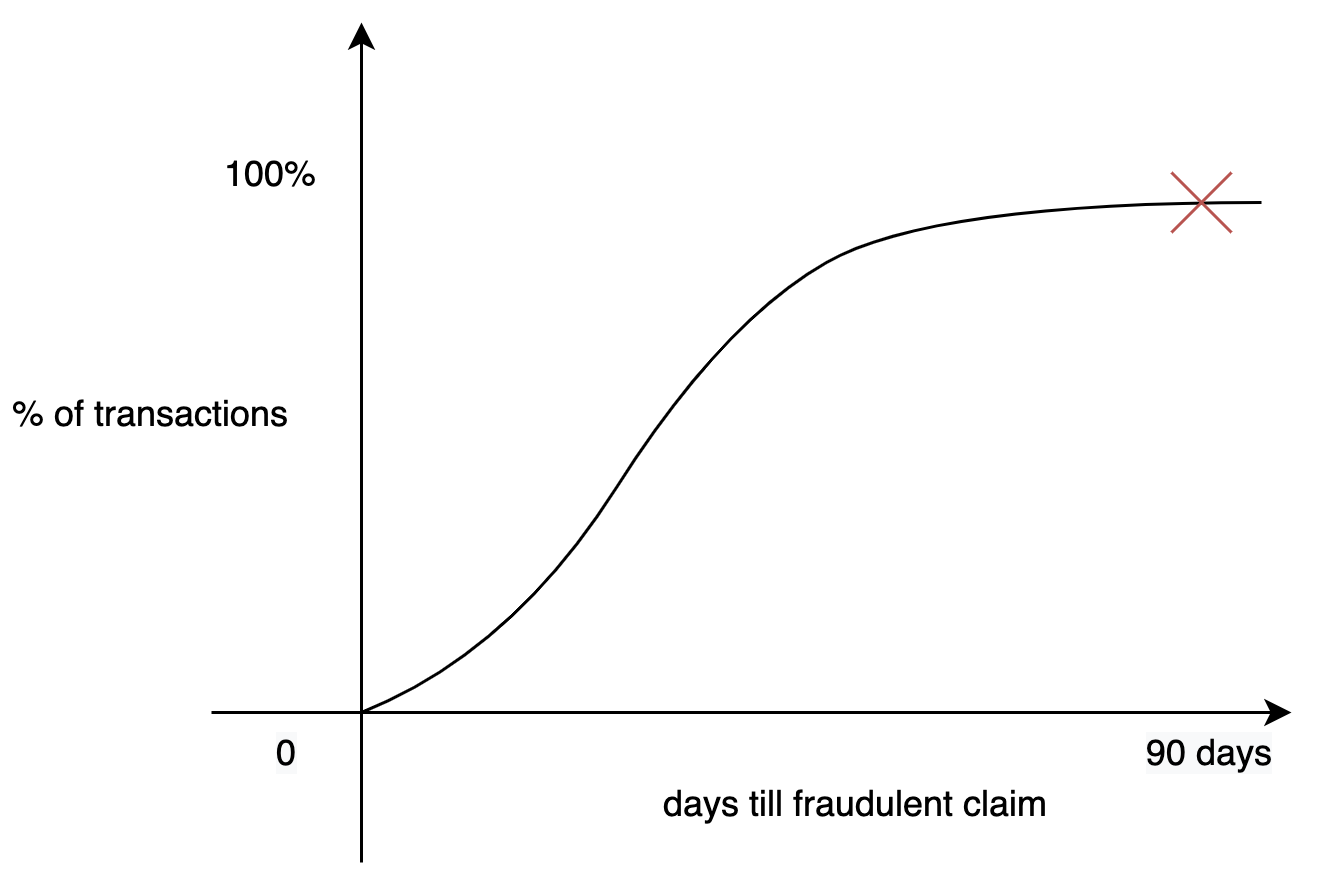

In [5]:
from IPython.display import Image
Image(filename='misc/fraud_graph.png', width=400) 

If the graph above is something we would have gotten, we can assume 3 months is a good time to wait for a lable. 

Let's think through potential indicator of Fraudulent transactions.

1. **Number of past fraudulent & non-fraudulent transactions associated with buyer**: Let's say we only know the labels 3 months after the transactions have occurred. The hunch is that more past fraud transactions means more chances of fraud
2. **Number of past fraudulent & non-fraudulent transactions associated with merchant**: The hunch is that more past fraud transactions means more chances of fraud
3. **Purchase Amount**: Hunch is that higher price implies higher fraud
4. **Location**: If fraud is associated with deliveries, location would be worth considering (like zipzone prefix as a categorical variable). The hunch would be that shady areas where packages are delivered could be subject to theft (fraud in this case)

In [5]:
query = load_query('queries/base.sql')
data = pysqldf(query)

In [15]:
data.sample()

,label,transaction_id,user_id,price,location,merchant,category,num_transactions,no_past_transactions,mean_price,...,no_fraudulent_past_transactions,mean_price_fraudulent,num_merchant_transactions,no_merchant_past_transactions,mean_price_merchant,num_fraudulent_merchant_transactions,no_merchant_fraudulent_past_transactions,mean_price_merchant_fraudulent,fraud_rate_user,fraud_rate_merchant
65690,0,46a92a905c47b52b2fc45d4acbc22e74,676173792455,28.14,904,fraud_Pacocha-Weissnat,kids_pets,139.0,0,76.432847,...,1,NaN,168,0,61.390764,NaN,1,NaN,0.0,0


### Create Model

In [7]:
def undersample(X, y, ratio=4):
    pos_size = y.sum() 
    neg_size = int(pos_size * ratio)
    y_pos, y_neg = y[y==1], y[y==0]
    X_pos, X_neg = X.loc[y_pos.index], X.loc[y_neg.index]
    idxs = y_neg.sample(neg_size).index # Random sampled indexes
    undersampled_y_neg = y.loc[idxs] 
    undersampled_X_neg = X.loc[idxs] 
    return pd.concat([X_pos, undersampled_X_neg]), pd.concat([y_pos, undersampled_y_neg])

In [8]:
categorical_features = ['location', 
                       'merchant', 
                       'category', 
                       'no_past_transactions',
                       'no_fraudulent_past_transactions', 
                       'no_merchant_past_transactions',
                       'no_merchant_fraudulent_past_transactions']
numerical_features = ['price', 
                     'num_transactions',
                     'mean_price',
                     'num_fraudulent_transactions', 
                     'mean_price_fraudulent',
                     'num_merchant_transactions',
                     'mean_price_merchant',
                     'num_fraudulent_merchant_transactions',
                     'mean_price_merchant_fraudulent',
                     'fraud_rate_user',
                     'fraud_rate_merchant']
label_column = 'label'
UNDERSAMPLE_RATIO = 4
X, y = data[categorical_features + numerical_features], data[label_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
undersampled_X_train, undersampled_y_train = undersample(X_train, y_train, ratio=UNDERSAMPLE_RATIO)
cat = [([c], [
              SimpleImputer(strategy='constant', fill_value=-1), 
              OrdinalEncoder(dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)
            ]) for c in categorical_features]
num = [([n], [SimpleImputer()]) for n in numerical_features]
mapper = DataFrameMapper(cat + num, df_out=True)
clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    metric_period=100,
    scale_pos_weight=UNDERSAMPLE_RATIO,
    cat_features=categorical_features)
pipeline = Pipeline([
    ('preprocess', mapper),
    ('clf', clf)
])
p = pipeline.fit(
    undersampled_X_train,
    undersampled_y_train)

0:	learn: 0.5792790	total: 72.7ms	remaining: 1m 12s
100:	learn: 0.0452843	total: 745ms	remaining: 6.63s
200:	learn: 0.0205734	total: 1.66s	remaining: 6.58s
300:	learn: 0.0117691	total: 2.36s	remaining: 5.48s
400:	learn: 0.0084055	total: 3.05s	remaining: 4.56s
500:	learn: 0.0077469	total: 3.66s	remaining: 3.64s
600:	learn: 0.0075046	total: 4.25s	remaining: 2.82s
700:	learn: 0.0073597	total: 4.83s	remaining: 2.06s
800:	learn: 0.0065830	total: 5.44s	remaining: 1.35s
900:	learn: 0.0063660	total: 6.02s	remaining: 662ms
999:	learn: 0.0061565	total: 6.6s	remaining: 0us


### Evaluation

In [18]:
def evaluate(pipeline, X, y):
    y_predict_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = y_predict_proba >= 0.5
    precision, recall, _ = precision_recall_curve(y, y_predict_proba)
    return{
        'PR AUC': auc(recall, precision),
        'cofusion_matrix': confusion_matrix(y, y_pred),
        'count': y.shape[0]
    }

In [19]:
train_metrics = evaluate(pipeline, X_train, y_train)
test_metrics = evaluate(pipeline, X_test, y_test)

In [13]:
train_metrics

{'PR AUC': 0.8591991238663205,
 'cofusion_matrix': array([[88328,  1160],
        [    4,   508]]),
 'count': 90000}

In [14]:
test_metrics

{'PR AUC': 0.83210051068029,
 'cofusion_matrix': array([[9813,  124],
        [   5,   58]]),
 'count': 10000}

Some takeaways:
- There were 63 (5 + 58) cases of fraud and we predicted 58 of them during the transaction time itself.
- There were 58 cases that were actually fraudulent & we predicted fraudulent
- There were 5 cases that were actually fraudulent, but predicted as not fraudulent
- There were 124 cases that we predicted were fraudulent, but weren't actually. 
- The remaining 9,813 cases were normal transactions that were not flagged by the model

### Model Interpretation

In [36]:
import shap
shap.initjs()
preprocessed_X_test = mapper.transform(X_test)
shap_values = clf.copy().get_feature_importance(
    Pool(preprocessed_X_test, y_test, cat_features=categorical_features), 
    type='ShapValues')
expected_value = shap_values[0, -1]
s = shap_values[:, :-1]

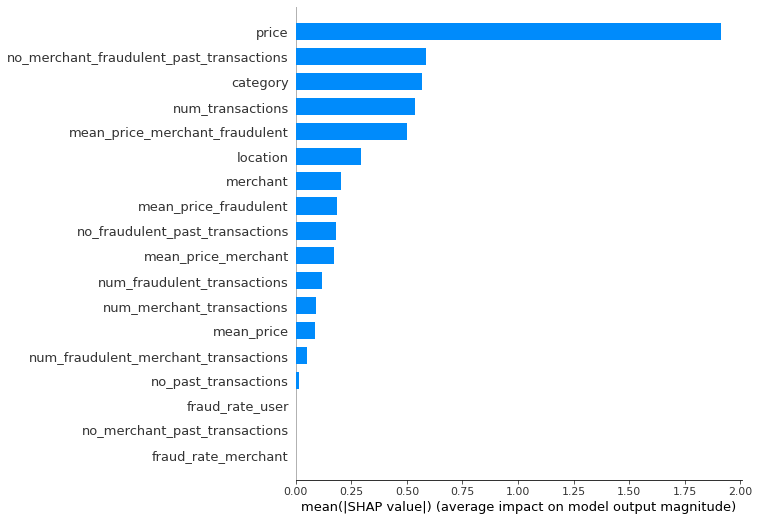

In [44]:
shap.summary_plot(s, X_train, plot_type='bar')

In [82]:
y_predict_proba = pipeline.predict_proba(X_test)[:, 1]

In [94]:
label_df = pd.DataFrame(y_test, columns=['label']).reset_index().drop('index', axis=1)
pred_df = pd.DataFrame(y_predict_proba, columns=['predictions'])

In [96]:
final_df = pd.concat([X_test.reset_index().drop('index', axis=1), label_df, pred_df], axis=1)

Let's take a look at a non-fraudulent sample

In [101]:
idx = 3
final_df.iloc[idx:idx+1]

,location,merchant,category,no_past_transactions,no_fraudulent_past_transactions,no_merchant_past_transactions,no_merchant_fraudulent_past_transactions,price,num_transactions,mean_price,num_fraudulent_transactions,mean_price_fraudulent,num_merchant_transactions,mean_price_merchant,num_fraudulent_merchant_transactions,mean_price_merchant_fraudulent,fraud_rate_user,fraud_rate_merchant,label,predictions
3,689,fraud_Romaguera and Sons,travel,0,0,0,1,6.84,91.0,63.87983,1.0,759.4,49,100.955067,NaN,NaN,0.0,0,0,0.000373


In [73]:
shap.force_plot(expected_value, s[idx, :], preprocessed_X_test.iloc[idx, :])

Nice! This was a really low priced transaction, and the person never made a fraudulent transaction in the past. So the probability of fraud is pushed down

Now lets take a look at a fraudulent sample

In [99]:
idx = 121
final_df.iloc[idx:idx+1]

,location,merchant,category,no_past_transactions,no_fraudulent_past_transactions,no_merchant_past_transactions,no_merchant_fraudulent_past_transactions,price,num_transactions,mean_price,num_fraudulent_transactions,mean_price_fraudulent,num_merchant_transactions,mean_price_merchant,num_fraudulent_merchant_transactions,mean_price_merchant_fraudulent,fraud_rate_user,fraud_rate_merchant,label,predictions
121,779,fraud_Medhurst PLC,shopping_net,0,0,0,0,1032.1,122.0,61.339841,1.0,1032.1,140,61.05389,3.0,1006.70989,0.0,0,1,0.999193


In [100]:
shap.force_plot(expected_value, s[idx, :], preprocessed_X_test.iloc[idx, :])

Looks like the high price really pushed probability of fraud up! Along with the fact this person commited fraud in the past!

In [110]:
final_df[['category', 'label']].groupby('category')['label'].sum().sort_values(ascending=False)

category
grocery_pos       12
shopping_net      12
misc_net          10
personal_care      7
shopping_pos       7
grocery_net        4
misc_pos           3
food_dining        2
health_fitness     2
kids_pets          2
entertainment      1
gas_transport      1
home               0
travel             0
Name: label, dtype: int64

### Exercise

The model interpretation doesn't give the direction of behavior. Try plotting `partial dependency plots` between the label and every feature to get directional importance

This model interpretation constructed shapely values from catboost. But you can determine shapely values using `shap` for any model. (Refer my other github repo on model interpretability if you feel like giving up): https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb